## PART 1: Preprocessing data

In [12]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from autocorrect import Speller

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from wordcloud import WordCloud

random_seed=100
np.random.seed(random_seed)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
df=pd.read_csv("Google Review_merge_review.csv")

In [14]:
df.shape

(13935, 32)

In [15]:
df.isna().sum()

id                           0
object                       0
result_position              0
cid                          0
internal_review_id           0
is_user_local_guide          0
lang                      3749
origin                       0
place_id                     0
place_name                5836
published_at                 0
published_at_datetime        0
pictures                 10681
place_average_score          0
review_link                  0
response_from_owner      11928
score                        0
text                      3825
total_likes                  0
total_reviews                0
user_name                    0
user_link                    0
user_internal_id             0
user_reviews_count           0
user_image_url               0
visited_in               13935
zero_x                       0
collected_at                 0
input_url                    0
input_sort_by                0
input_language               0
SourceFile                   0
dtype: i

In [16]:
import re

# Define a function to extract the place name from a URL
def extract_place_name(url):
    match = re.search(r'/place/([^/]+)/', url)
    if match:
        return match.group(1).replace('+', ' ')
    else:
        return None

# Apply the function to each element in the 'input_url' column
df['place_name'] = df['input_url'].apply(extract_place_name)

# Display the updated DataFrame
df['place_name'].head()

0    Dharma Garden Vegetarian Restaurant
1    Dharma Garden Vegetarian Restaurant
2    Dharma Garden Vegetarian Restaurant
3    Dharma Garden Vegetarian Restaurant
4    Dharma Garden Vegetarian Restaurant
Name: place_name, dtype: object

### Drop duplicate, null values

In [17]:
data=df[['id','text','score','place_name','total_likes','published_at_datetime']]

In [18]:
#drop duplicate data with two condition from 
data = data.drop_duplicates(subset=['place_name','text','score'], keep='first')
#drop null value in review texts
data = data.dropna(subset=['text'])
data.shape

(8735, 6)

In [19]:
data.isna().sum()

id                       0
text                     0
score                    0
place_name               0
total_likes              0
published_at_datetime    0
dtype: int64

## Format data type

In [20]:
data.dtypes

id                        int64
text                     object
score                     int64
place_name               object
total_likes               int64
published_at_datetime    object
dtype: object

In [21]:
data.head()

,id,text,score,place_name,total_likes,published_at_datetime
0,8151070,Delicious vegetarian food at Phu Nhuan in HCMC...,5,Dharma Garden Vegetarian Restaurant,0,2024-03-28 05:58:49.260627+00
1,8151071,Lovely vegetarian restaurant. Highly recommend...,5,Dharma Garden Vegetarian Restaurant,3,2022-09-08 07:19:06.413139+00
2,8151072,One of the best vegetarian Restaurant in Saigo...,5,Dharma Garden Vegetarian Restaurant,0,2024-03-12 15:25:05.606682+00
3,8151073,One of the best vegetarian restaurants.i could...,5,Dharma Garden Vegetarian Restaurant,1,2018-11-21 14:25:05.591602+00
4,8151074,Quaint vegetarian shop that has its group of l...,5,Dharma Garden Vegetarian Restaurant,0,2023-11-17 06:53:31.786393+00


In [22]:
#'published_at_datetime' column should only contains %y %m %d
#but first convert this to string to split before convert again to datetime
data['published_at_datetime'] = data['published_at_datetime'].astype(str)
data['published_at_datetime'] = data['published_at_datetime'].str.split(' ', n=1).str[0]
#conver again to datatime
data['published_at_datetime'] = pd.to_datetime(data['published_at_datetime'], errors='coerce')
data.head()

,id,text,score,place_name,total_likes,published_at_datetime
0,8151070,Delicious vegetarian food at Phu Nhuan in HCMC...,5,Dharma Garden Vegetarian Restaurant,0,2024-03-28
1,8151071,Lovely vegetarian restaurant. Highly recommend...,5,Dharma Garden Vegetarian Restaurant,3,2022-09-08
2,8151072,One of the best vegetarian Restaurant in Saigo...,5,Dharma Garden Vegetarian Restaurant,0,2024-03-12
3,8151073,One of the best vegetarian restaurants.i could...,5,Dharma Garden Vegetarian Restaurant,1,2018-11-21
4,8151074,Quaint vegetarian shop that has its group of l...,5,Dharma Garden Vegetarian Restaurant,0,2023-11-17


In [23]:
def preprocess_text(text):
    if pd.isnull(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Correct spelling errors
    spell = Speller()
    words = [spell(word) for word in words]

    # Join the words back into a single string
    processed_text = ' '.join(words)
    return processed_text

# Apply preprocessing to the 'review' column
data['processed_review'] = data['text'].apply(preprocess_text)

## PART 2: Topic Moddeling with LDA

### Identify optimal number of topics

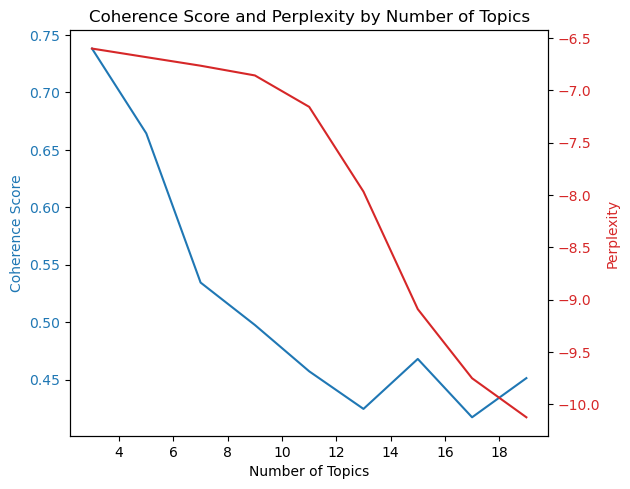

In [24]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# Set random seed for reproducibility
random_seed = 100
np.random.seed(random_seed)

# Tokenize the processed content
processed_content = data['processed_review'].apply(lambda x: x.split())

# Create Dictionary
id2word = corpora.Dictionary(processed_content)

# Create Corpus
texts = processed_content

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

def compute_metrics(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=100,
                                       update_every=2,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        
        # Coherence
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        # Perplexity
        perplexity_values.append(model.log_perplexity(corpus))
        
    return model_list, coherence_values, perplexity_values

# Compute coherence and perplexity values
limit = 20; start = 3; step = 2;
model_list, coherence_values, perplexity_values = compute_metrics(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score', color=color)
ax1.plot(x, coherence_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Perplexity', color=color)  # we already handled the x-label with ax1
ax2.plot(x, perplexity_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Coherence Score and Perplexity by Number of Topics')
plt.show()

### Generate word cloud

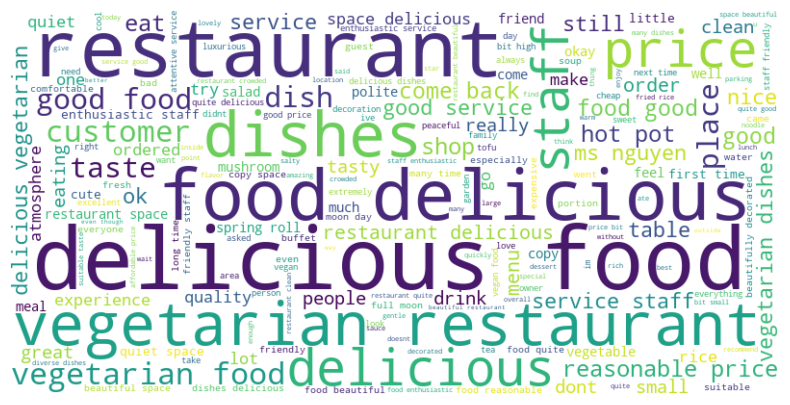

In [25]:
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Combine all processed reviews into a single string
all_reviews = ' '.join(data['processed_review'])
generate_word_cloud(all_reviews)

### Performing LDA

In [26]:
def lda_topic_modeling(texts, num_topics=4, num_words=10):
    # Vectorize the text
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(texts)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(dtm)

    # Get the words corresponding to each topic
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(lda.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[-num_words:]]
        topics[f'Topic {idx+1}'] = topic_words
    return topics

# Apply LDA to the processed reviews
topics = lda_topic_modeling(data['processed_review'])
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: enthusiastic, vegetarian, beautiful, staff, good, service, space, restaurant, food, delicious
Topic 2: vegan, staff, service, nice, great, restaurant, vegetarian, good, place, food
Topic 3: dish, like, bit, price, quite, vegetarian, food, delicious, dishes, restaurant
Topic 4: space, bit, beautifully, quite, restaurant, ok, pot, hot, food, delicious


## PART 3: Sentiment using Vader

In [27]:
# We now make the sentiment analyzer objects
analyzer=SentimentIntensityAnalyzer()

In [28]:
# First, we run polarity score on the text to see it's reflection
# make a dictionary res for storing the result
res = {} 
for i, row in tqdm(data.iterrows(), total=len(data)): 
    #The tqdm function helps track the progress of the loop, especially useful for large datasets
    text = row['processed_review'] 
    #text  are assigned the values of the 'Text' columns of the current row
    myid = row['id'] 
    #similar to text
    res[myid] = analyzer.polarity_scores(text) #every time we loop, the result of different sentiment scores is stored in the res dictionary with myid as the key

  0%|          | 0/8735 [00:00<?, ?it/s]

In [29]:
# Now we showing the result of the sentiment score as dataframe varder, T is transposing the DataFrame
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={'index': 'id'})
vader = vader.merge(data, how='left')
#merges the vaders DataFrame with the original DataFrame data using a left join on the Id column
vader.head()

,id,neg,neu,pos,compound,text,score,place_name,total_likes,published_at_datetime,processed_review
0,8151070,0.000,0.730,0.270,0.5719,Delicious vegetarian food at Phu Nhuan in HCMC...,5,Dharma Garden Vegetarian Restaurant,0,2024-03-28,delicious vegetarian food hu chuan cmc price r...
1,8151071,0.041,0.612,0.348,0.9950,Lovely vegetarian restaurant. Highly recommend...,5,Dharma Garden Vegetarian Restaurant,3,2022-09-08,lovely vegetarian restaurant highly recommend ...
2,8151072,0.000,0.448,0.552,0.9231,One of the best vegetarian Restaurant in Saigo...,5,Dharma Garden Vegetarian Restaurant,0,2024-03-12,one best vegetarian restaurant saison loved ev...
3,8151073,0.000,0.830,0.170,0.8126,One of the best vegetarian restaurants.i could...,5,Dharma Garden Vegetarian Restaurant,1,2018-11-21,one best vegetarian restaurants could ten spri...
4,8151074,0.000,0.781,0.219,0.7096,Quaint vegetarian shop that has its group of l...,5,Dharma Garden Vegetarian Restaurant,0,2023-11-17,quaint vegetarian shop group loyal customers t...


In [30]:
def categorize_sentiment(score):
    if score > 3:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'
vader['sentiment_score'] = vader['score'].apply(categorize_sentiment)
vader

,id,neg,neu,pos,compound,text,score,place_name,total_likes,published_at_datetime,processed_review,sentiment_score
0,8151070,0.000,0.730,0.270,0.5719,Delicious vegetarian food at Phu Nhuan in HCMC...,5,Dharma Garden Vegetarian Restaurant,0,2024-03-28,delicious vegetarian food hu chuan cmc price r...,Positive
1,8151071,0.041,0.612,0.348,0.9950,Lovely vegetarian restaurant. Highly recommend...,5,Dharma Garden Vegetarian Restaurant,3,2022-09-08,lovely vegetarian restaurant highly recommend ...,Positive
2,8151072,0.000,0.448,0.552,0.9231,One of the best vegetarian Restaurant in Saigo...,5,Dharma Garden Vegetarian Restaurant,0,2024-03-12,one best vegetarian restaurant saison loved ev...,Positive
3,8151073,0.000,0.830,0.170,0.8126,One of the best vegetarian restaurants.i could...,5,Dharma Garden Vegetarian Restaurant,1,2018-11-21,one best vegetarian restaurants could ten spri...,Positive
4,8151074,0.000,0.781,0.219,0.7096,Quaint vegetarian shop that has its group of l...,5,Dharma Garden Vegetarian Restaurant,0,2023-11-17,quaint vegetarian shop group loyal customers t...,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
8730,8083871,0.000,0.213,0.787,0.5719,Delicious food,4,Thien Y Buffet Vegan Restaurant,0,2019-09-25,delicious food,Positive
8731,8083879,0.000,0.217,0.783,0.5574,Rich dishes,4,Thien Y Buffet Vegan Restaurant,0,2020-08-02,rich dishes,Positive
8732,8083881,0.000,0.000,1.000,0.2023,Fine,3,Thien Y Buffet Vegan Restaurant,0,2020-10-09,fine,Neutral
8733,8083883,0.000,1.000,0.000,0.0000,Temporary,4,Thien Y Buffet Vegan Restaurant,0,2018-07-17,temporary,Positive


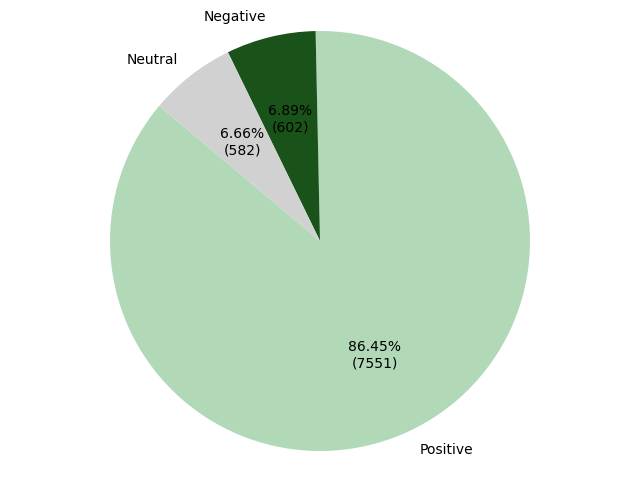

In [49]:
import matplotlib.pyplot as plt

# Define the color palette
colors = ['#b1d8b7', '#1a5319', '#d1d1d1']

# Assuming 'sen_count' is already defined
sen_count = vader['sentiment_score'].value_counts()

plt.figure(figsize=(8, 6))

def absolute_value(val):
    a = int(val / 100. * sen_count.sum())
    return f'{val:.2f}%\n({a})'

# Use the provided color palette
plt.pie(sen_count.values, labels=sen_count.index, autopct=absolute_value, startangle=140, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [32]:
# Define a function to categorize sentiment
pd.set_option('display.max_colwidth', None)
def review_sentiment(score):
    if score >= 0.5:
        return 'Positive'
    elif score <-0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the 'compound' score to create a new column
vader['sentiment_review'] = vader['compound'].apply(review_sentiment)
vader.head()

,id,neg,neu,pos,compound,text,score,place_name,total_likes,published_at_datetime,processed_review,sentiment_score,sentiment_review
0,8151070,0.000,0.730,0.270,0.5719,Delicious vegetarian food at Phu Nhuan in HCMC. The price is reasonable about 40-50 vnd per dish.,5,Dharma Garden Vegetarian Restaurant,0,2024-03-28,delicious vegetarian food hu chuan cmc price reasonable vnd per dish,Positive,Positive
1,8151071,0.041,0.612,0.348,0.9950,"Lovely vegetarian restaurant. Highly recommend for literally everyone because this place is worth the try. Space: big restaurant with 2 floors. Lots of seating choice. The ambience is warm, kind and cosy with the dimmed orange lights (which is spot on for me who doesn't light extra bright white lights). Seatings are comfy. Tables are big and weren't placed literally an arm length from one another. Food: scrumptious food with lots of choices. Well seasoned, well balance, not too oily. The tofu was a but salty but it was supposed to be paired with rice so no complaint. Their signature rice is great, i could feel the herbaceous aftertaste which was my fave part. Stir fried was fresh. Their spring rolls were super super good, gooey yam fillings. Fried wonton could be improved though since it was a little too flat, there was no volume to the shape, texture while the fillings was spot on. Ice tea is free fyi. Price: super affordable. We had a big meals with 5 dishes or so and it costed 210k, which came to our surprise despite the prices were already listed in the menu lol. It just felt like we ate a lot, that's why. Parking: a bit chaotic since you just park wherever at the fron gate and the security guard would handle the rest. Also, the guard was extremely helpful and polite, this man needs a raise! Overall, such a pleasant experience. Defo coming back to try out more.",5,Dharma Garden Vegetarian Restaurant,3,2022-09-08,lovely vegetarian restaurant highly recommend literally everyone place worth try space big restaurant floors lots seating choice audience warm kind copy dammed orange lights spot doesnt light extra bright white lights settings com tables big weren placed literally arm length one another food scrumptious food lots choices well seasoned well balance oily tofu salty supposed paired rice complaint signature rice great could feel herbaceous aftertaste have part stir fried fresh spring rolls super super good goofy yam fillings fried onto could improved though since little flat volume shape texture fillings spot ice tea free fyi price super affordable big meals dishes hosted k came surprise despite prices already listed menu lol felt like ate lot thats parking bit chaotic since park wherever from gate security guard would handle rest also guard extremely helpful polite man needs raise overall pleasant experience def coming back try,Positive,Positive
2,8151072,0.000,0.448,0.552,0.9231,One of the best vegetarian Restaurant in Saigon! Loved every food over there and their veg fried rice is best in the city!,5,Dharma Garden Vegetarian Restaurant,0,2024-03-12,one best vegetarian restaurant saison loved every food veg fried rice best city,Positive,Positive
3,8151073,0.000,0.830,0.170,0.8126,"One of the best vegetarian restaurants.i could have ten of their spring rolls and still want more!!! I didn't take a pic of the rolls because it was so good I couldn't wait. The first photo: vegan egg noodles soup and spicy beef noodles soup (it needs to be more spicy tho). Second photo: office lunch meal (meal changes everyday, come in and just order office lunch meal and they bring it out for you)",5,Dharma Garden Vegetarian Restaurant,1,2018-11-21,one best vegetarian restaurants could ten spring rolls still want didnt take pic rolls good couldnt wait first photo vegan egg noodles soup spicy beef noodles soup needs spicy tho second photo office lunch meal meal changes everyday come order office lunch meal bring,Positive,Positive
4,8151074,0.000,0.781,0.219,0.7096,Quaint vegetarian shop that has its group of l

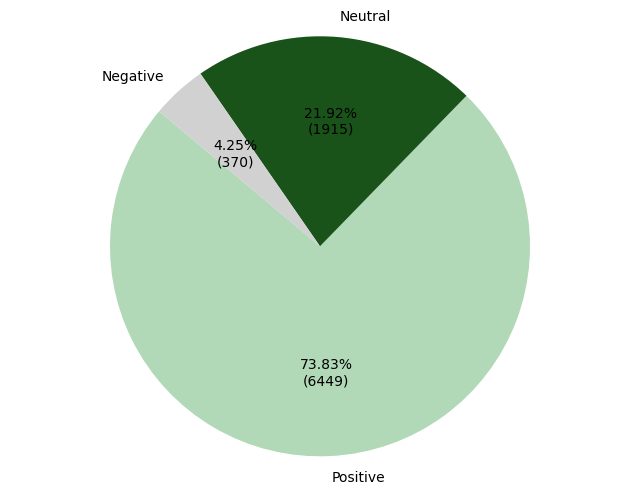

In [50]:
import matplotlib.pyplot as plt

# Define the color palette
colors = ['#b1d8b7', '#1a5319', '#d1d1d1']

# Assuming 'sen_count' is already defined
sen_count = vader['sentiment_review'].value_counts()

plt.figure(figsize=(8, 6))

def absolute_value(val):
    a = int(val / 100. * sen_count.sum())
    return f'{val:.2f}%\n({a})'

# Use the provided color palette
plt.pie(sen_count.values, labels=sen_count.index, autopct=absolute_value, startangle=140, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [34]:
# COMPARE RESULT
vader['Sentiment_Comparison'] = vader.apply(lambda x: 'Agree' if x['sentiment_review'] == x['sentiment_score'] else 'Disagree', axis=1)
vader

,id,neg,neu,pos,compound,text,score,place_name,total_likes,published_at_datetime,processed_review,sentiment_score,sentiment_review,Sentiment_Comparison
0,8151070,0.000,0.730,0.270,0.5719,Delicious vegetarian food at Phu Nhuan in HCMC. The price is reasonable about 40-50 vnd per dish.,5,Dharma Garden Vegetarian Restaurant,0,2024-03-28,delicious vegetarian food hu chuan cmc price reasonable vnd per dish,Positive,Positive,Agree
1,8151071,0.041,0.612,0.348,0.9950,"Lovely vegetarian restaurant. Highly recommend for literally everyone because this place is worth the try. Space: big restaurant with 2 floors. Lots of seating choice. The ambience is warm, kind and cosy with the dimmed orange lights (which is spot on for me who doesn't light extra bright white lights). Seatings are comfy. Tables are big and weren't placed literally an arm length from one another. Food: scrumptious food with lots of choices. Well seasoned, well balance, not too oily. The tofu was a but salty but it was supposed to be paired with rice so no complaint. Their signature rice is great, i could feel the herbaceous aftertaste which was my fave part. Stir fried was fresh. Their spring rolls were super super good, gooey yam fillings. Fried wonton could be improved though since it was a little too flat, there was no volume to the shape, texture while the fillings was spot on. Ice tea is free fyi. Price: super affordable. We had a big meals with 5 dishes or so and it costed 210k, which came to our surprise despite the prices were already listed in the menu lol. It just felt like we ate a lot, that's why. Parking: a bit chaotic since you just park wherever at the fron gate and the security guard would handle the rest. Also, the guard was extremely helpful and polite, this man needs a raise! Overall, such a pleasant experience. Defo coming back to try out more.",5,Dharma Garden Vegetarian Restaurant,3,2022-09-08,lovely vegetarian restaurant highly recommend literally everyone place worth try space big restaurant floors lots seating choice audience warm kind copy dammed orange lights spot doesnt light extra bright white lights settings com tables big weren placed literally arm length one another food scrumptious food lots choices well seasoned well balance oily tofu salty supposed paired rice complaint signature rice great could feel herbaceous aftertaste have part stir fried fresh spring rolls super super good goofy yam fillings fried onto could improved though since little flat volume shape texture fillings spot ice tea free fyi price super affordable big meals dishes hosted k came surprise despite prices already listed menu lol felt like ate lot thats parking bit chaotic since park wherever from gate security guard would handle rest also guard extremely helpful polite man needs raise overall pleasant experience def coming back try,Positive,Positive,Agree
2,8151072,0.000,0.448,0.552,0.9231,One of the best vegetarian Restaurant in Saigon! Loved every food over there and their veg fried rice is best in the city!,5,Dharma Garden Vegetarian Restaurant,0,2024-03-12,one best vegetarian restaurant saison loved every food veg fried rice best city,Positive,Positive,Agree
3,8151073,0.000,0.830,0.170,0.8126,"One of the best vegetarian restaurants.i could have ten of their spring rolls and still want more!!! I didn't take a pic of the rolls because it was so good I couldn't wait. The first photo: vegan egg noodles soup and spicy beef noodles soup (it needs to be more spicy tho). Second photo: office lunch meal (meal changes everyday, come in and just order office lunch meal and they bring it out for you)",5,Dharma Garden Vegetarian Restaurant,1,2018-11-21,one best vegetarian restaurants could ten spring rolls still want didnt take pic rolls good couldnt wait first photo vegan egg noodles soup spicy beef noodles soup needs spicy tho second photo office lunch meal meal changes everyday come order office lunch meal bring,Positive,Positive,Agree
4,8151074,0.000,0.781,0.219,0.7096,Q

In [35]:
agreement_percentage = (vader['sentiment_review'] == vader['sentiment_score']).mean() * 100
print(f"Agreement Percentage: {agreement_percentage:.2f}%")

Agreement Percentage: 75.27%


In [36]:
'''
As the percentage is quite high (>70%) so we can take either sentiment from the score or from the reviews
'''

'\nAs the percentage is quite high (>70%) so we can take either sentiment from the score or from the reviews\n'

### Performing LDA for Positive Reviews

In [37]:
vader_positive=vader[vader['sentiment_review'] == 'Positive']
vader_negative=vader[vader['sentiment_review'] == 'Negative']

In [38]:
def lda_topic_modeling_P(texts, num_topics=4, num_words=10):
    # Vectorize the text
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(texts)
    
    # Apply LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(dtm)
    
    # Get the words corresponding to each topic
    feature_names = vectorizer.get_feature_names_out()
    topics_P = {}
    for idx, topic in enumerate(lda.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[-num_words:]]
        topics[f'Topic {idx+1}'] = topic_words
    return topics
    
# Apply LDA to the processed reviews
topics_P = lda_topic_modeling_P(vader_positive['processed_review'])
for topic, words in topics_P.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: atmosphere, vegan, nice, restaurant, good, dishes, great, place, food, vegetarian
Topic 2: dish, bit, price, vegetarian, quite, restaurant, dishes, space, food, delicious
Topic 3: enthusiastic, vegetarian, beautiful, staff, good, space, service, restaurant, food, delicious
Topic 4: customers, eat, bit, day, quite, staff, time, crowded, food, restaurant


In [39]:
pd.set_option('display.max_colwidth', None)
"""
this part is to find the words in the process reviews to understand the context before droping or acepting the words
"""
def find_rows_with_words(dataframe, column, words, condition='and'):
    regex_patterns = [rf'\b{re.escape(word)}\b' for word in words]
    
    if condition == 'and':
        mask = dataframe[column].apply(lambda text: all(re.search(pattern, text, re.IGNORECASE) for pattern in regex_patterns))
    elif condition == 'or':
        mask = dataframe[column].apply(lambda text: any(re.search(pattern, text, re.IGNORECASE) for pattern in regex_patterns))
    else:
        raise ValueError("Condition must be either 'and' or 'or'")
    
    return dataframe[mask]
                                                    #change the list of word
find=find_rows_with_words(vader_positive,'processed_review',['food','thai'], condition='and') #can change the condition to 'or'
find[['id','text','processed_review']]

,id,text,processed_review
170,8151254,"The vegetarian restaurant has good food and reasonable prices, so my family often eats here. Normally the restaurant is already crowded, but it's even more crowded during the full moon. I called today to reserve a table, but when I got there, the staff said they weren't accepting new orders :( Luckily, it wasn't crowded so it wasn't crowded so I still got a table. The quality is still ok. Banana salad with Thai hotpot It's delicious. Although Thai hot pot is not authentically Thai, it is better than Phap Uyen hot pot. Phap Uyen hot pot is just like mushroom hot pot, very bland.",vegetarian restaurant good food reasonable prices family often eats normally restaurant already crowded even crowded full moon called today reserve table got staff said weren accepting new orders lucky wasnt crowded wasnt crowded still got table quality still ok banana salad thai hotspot delicious although thai hot pot authentically thai better php yen hot pot php yen hot pot like mushroom hot pot bland
198,8151282,"The dishes are delicious, except for the Thai hot pot which is a bit salty and sour. I went during peak lunch time so I waited a bit for the food to arrive. In front of the shop there is a Syro tree, it looks very nice. The first time I learned about this tree, the parking attendants enthusiastically picked it and gave it a try.",dishes delicious except thai hot pot bit salty sour went peak lunch time waited bit food arrive front shop syr tree looks nice first time learned tree parking attendants enthusiastically picked gave try
828,8152054,"First time eating a vegetarian wedding at this restaurant. The space is quite cozy. Good service, quick. The food is okay. The soup is a bit salty. Delicious salad. The taste of Thai hot pot is nothing special. The projection screen was very blurry, the bride and groom could not be seen clearly.",first time eating vegetarian wedding restaurant space quite copy good service quick food okay soup bit salty delicious salad taste thai hot pot nothing special projection screen blurry bride groom could seen clearly
958,8152184,"The vegetarian buffet here is quite delicious... It tastes like you're eating a really salty dish... My favorites are the roasted duck with dumplings, Thai hot pot with stir-fried noodles with beef... For dessert, my favorite is Singaporean tofu hehe ...But the price is a bit steep... The meal on Sunday afternoon was 250k per ticket... The price is high but the food is delicious so it's ok",vegetarian buffet quite delicious tastes like youre eating really salty dish favorites roasted duck dumping thai hot pot stirred noodles beef dessert favorite singapore tofu here price bit steep meal sunday afternoon k per ticket price high food delicious ok
1363,8097162,"Pad Thai is not very good And kimbab is delicious Polite space, quite quiet It's just that the staff and managers gathered around and stood together quite loudly Even though the area I sat at only had 2 tables and all the food was ready, I had to wait until the second time to make the tea.",pad thai good simbad delicious polite space quite quiet staff managers gathered around stood together quite loudly even though area sat tables food ready wait second time make tea
...,...,...,...
8222,8144739,"Buffet price 289K/person. In my opinion, you should not order a buffet, because I find there are quite a few interesting dishes. I think the a la carte menu has more delicious dishes. Because my friend didn't know, I chose the buffet package. As for the food, I found some dishes like spring rolls, spring rolls, and banh xeo to be bad. The taste is unclear, the dipping sauce is also not delicious. But when it comes to fried dishes, I find them delicious. Like food - Mushroom with pepper sauce - Crispy fried mushrooms dipped in tamarind sauce - Mussels scooped with rice paper - Crispy tofu - Pad Thai - Stir-fried wild vegetables with garlic (this dish is delicious, second order) - Wild vegetables and ter

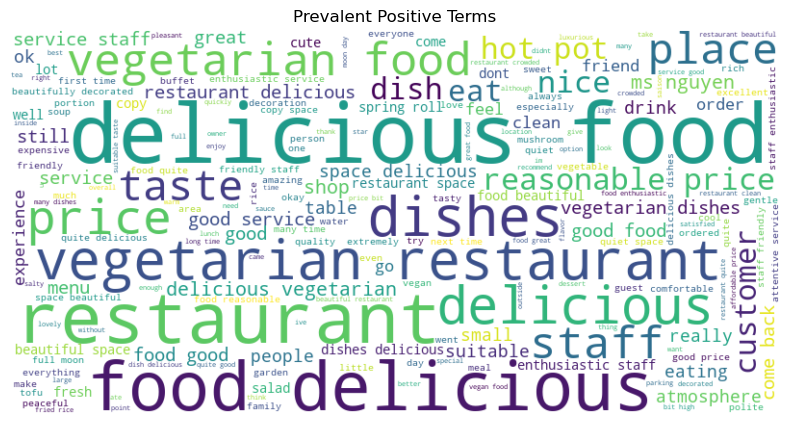

In [40]:
## word cloud for positive reviews
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Prevalent Positive Terms')
    plt.show()

# Combine all processed reviews into a single string
all_reviews = ' '.join(vader_positive['processed_review'])
generate_word_cloud(all_reviews)

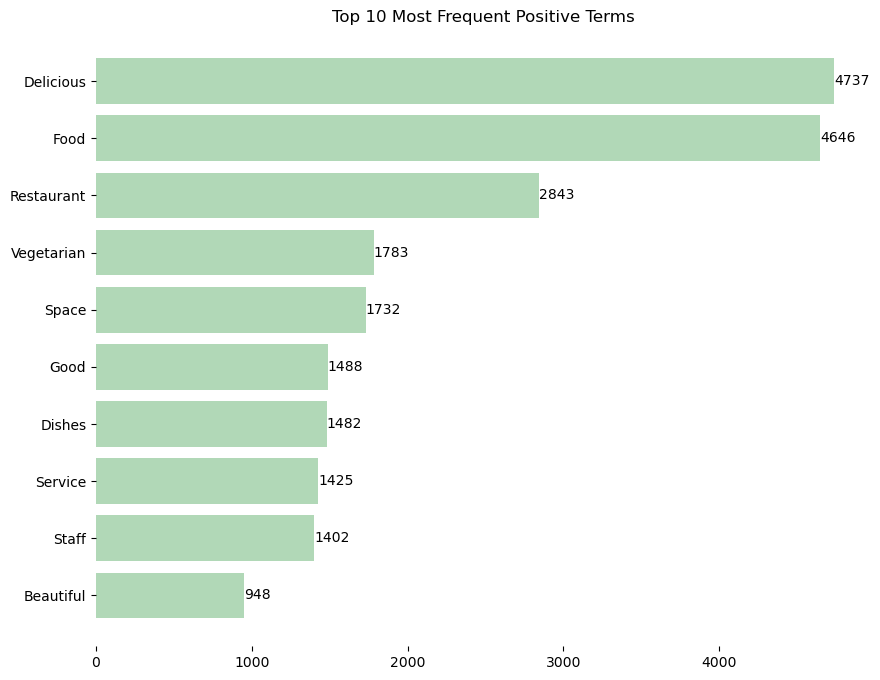

In [57]:
import matplotlib.pyplot as plt
from collections import Counter

# Define the function to find the most frequent words
def find_most_frequent_words(column, num_words):
    # Combine all rows in the column into one large string
    text = ' '.join(column)
    
    # Split the text into individual words
    words = text.split()
    
    # Count the frequency of each word
    word_counts = Counter(words)
    
    # Get the most common words
    most_common_words = word_counts.most_common(num_words)
    
    return most_common_words

# Assuming 'vader_negative' DataFrame is already defined and has a 'processed_review' column
most_frequent_nwords = find_most_frequent_words(vader_positive['processed_review'], 10)

# Extract words and their frequencies
words, frequencies = zip(*most_frequent_nwords)

# Capitalize the first letter of each word
words = [word.title() for word in words]

# Reverse the order for descending order in horizontal bar chart
words = words[::-1]
frequencies = frequencies[::-1]

# Plotting the horizontal bar chart with data labels
plt.figure(figsize=(10, 8))
bars = plt.barh(words, frequencies, color='#b1d8b7')

# Adding data labels on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2.0, int(bar.get_width()), va='center')

# Remove the border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.title('Top 10 Most Frequent Positive Terms')

plt.show()


###  Performing LDA for Negative Reviews

In [42]:
def lda_topic_modeling_N(texts, num_topics=4, num_words=10):
    # Vectorize the text
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(texts)
    
    # Apply LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(dtm)
    
    # Get the words corresponding to each topic
    feature_names = vectorizer.get_feature_names_out()
    topics_N = {}
    for idx, topic in enumerate(lda.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[-num_words:]]
        topics[f'Topic {idx+1}'] = topic_words
    return topics
    
# Apply LDA to the processed reviews
topics_N = lda_topic_modeling_N(vader_negative['processed_review'])
for topic, words in topics_P.items():
    print(f"{topic}: {', '.join(words)}")

Topic 1: order, expensive, ordered, dish, water, dishes, food, price, restaurant, rice
Topic 2: hot, vegetarian, place, staff, parking, table, time, service, restaurant, food
Topic 3: dont, come, attitude, time, staff, customers, restaurant, bad, food, service
Topic 4: went, bit, soup, staff, pot, day, hot, eat, vegetarian, restaurant


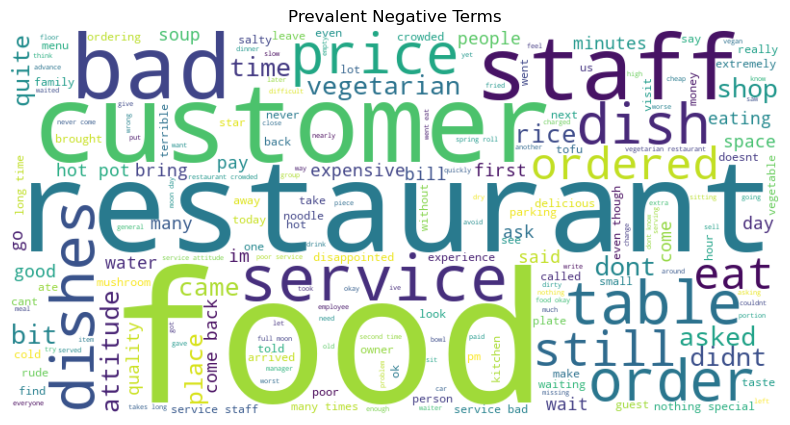

In [43]:
## word cloud for negative reviews
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Prevalent Negative Terms')
    plt.show()

# Combine all processed reviews into a single string
all_reviews = ' '.join(vader_negative['processed_review'])
generate_word_cloud(all_reviews)

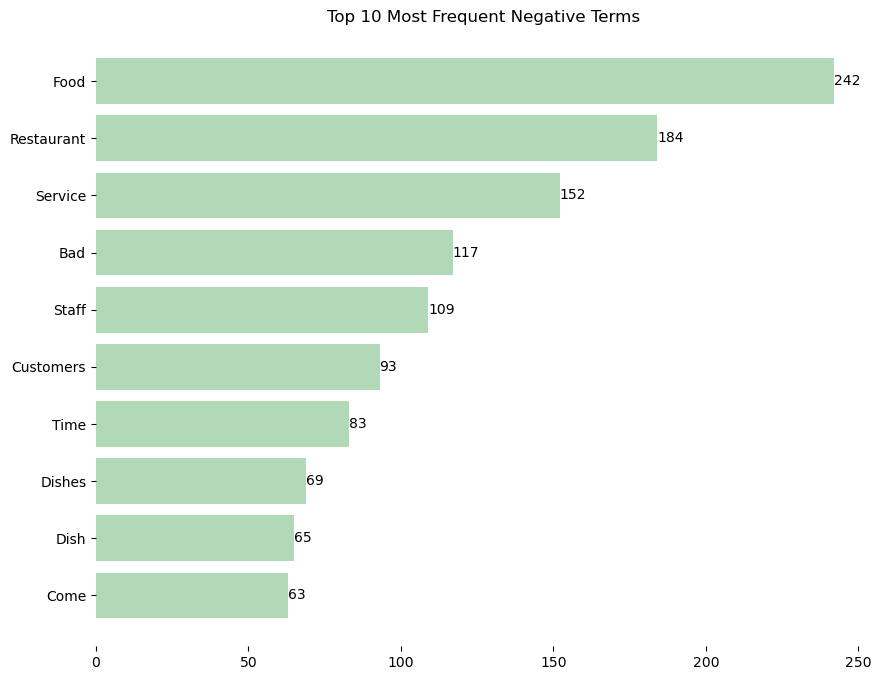

In [58]:
import matplotlib.pyplot as plt
from collections import Counter

# Define the function to find the most frequent words
def find_most_frequent_words(column, num_words):
    # Combine all rows in the column into one large string
    text = ' '.join(column)
    
    # Split the text into individual words
    words = text.split()
    
    # Count the frequency of each word
    word_counts = Counter(words)
    
    # Get the most common words
    most_common_words = word_counts.most_common(num_words)
    
    return most_common_words

# Assuming 'vader_negative' DataFrame is already defined and has a 'processed_review' column
most_frequent_nwords = find_most_frequent_words(vader_negative['processed_review'], 10)

# Extract words and their frequencies
words, frequencies = zip(*most_frequent_nwords)

# Capitalize the first letter of each word
words = [word.title() for word in words]

# Reverse the order for descending order in horizontal bar chart
words = words[::-1]
frequencies = frequencies[::-1]

# Plotting the horizontal bar chart with data labels
plt.figure(figsize=(10, 8))
bars = plt.barh(words, frequencies, color='#b1d8b7')

# Adding data labels on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2.0, int(bar.get_width()), va='center')

# Remove the border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.title('Top 10 Most Frequent Negative Terms')

plt.show()


In [ ]:
pd.set_option('display.max_colwidth', None)
"""
this part is to find the words in the process reviews to understand the context before droping or acepting the words
"""
def find_rows_with_words(dataframe, column, words, condition='and'):
    regex_patterns = [rf'\b{re.escape(word)}\b' for word in words]
    
    if condition == 'and':
        mask = dataframe[column].apply(lambda text: all(re.search(pattern, text, re.IGNORECASE) for pattern in regex_patterns))
    elif condition == 'or':
        mask = dataframe[column].apply(lambda text: any(re.search(pattern, text, re.IGNORECASE) for pattern in regex_patterns))
    else:
        raise ValueError("Condition must be either 'and' or 'or'")
    
    return dataframe[mask]
                                                    #change the list of word
find=find_rows_with_words(vader_negative,'processed_review',['staff', 'bad','service'], condition='and') #can change the condition to 'or'
find[['id','text','processed_review']]

# Assessing data before and after covid 19

## Before covid

## After covid 19

## Sub function